In [89]:
# import statements
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
from datetime import datetime, timedelta

from sqlalchemy import create_engine


#from snowflake.connector import connect
import snowflake.connector
from snowflake.snowpark import Session
from snowflake.snowpark.functions import col
from snowflake.snowpark.version import VERSION
from snowflake.connector import connect, Error
from snowflake.snowpark.functions import to_timestamp, datediff, col
from snowflake.snowpark.functions import avg, sum, col, udf, call_udf, call_builtin, year

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression

#train_test
from sklearn.model_selection import train_test_split

#Model
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor






In [90]:
connection_parameters = {
  "account": "wqkmqve-hh76255",
  "user": "SANDEEPMAILARKAR",
  "password": "Parkar@1234",
  "role": "ACCOUNTADMIN",
  "warehouse": "COMPUTE_WH",
  "database": "PREVENTIVE_HEALTHCARE",
  "schema": "LENGTHOFSTAY"
}

session = Session.builder.configs(connection_parameters).create()

print(f"Current Database and schema: {session.get_fully_qualified_current_schema()}")
print(f"Current Warehouse: {session.get_current_warehouse()}")

Current Database and schema: "PREVENTIVE_HEALTHCARE"."LENGTHOFSTAY"
Current Warehouse: "COMPUTE_WH"


In [91]:
#The Session Table is a utility table created for each individual instance of a user's access to a file.
ADMISSIONS_table = session.table('ADMISSIONS')
DIAGNOSES_ICD_table= session.table('DIAGNOSES_ICD')
ICUSTAYS_table = session.table('ICUSTAYS')
PATIENTS_table = session.table('PATIENTS')

print(type(ADMISSIONS_table))
print(type(DIAGNOSES_ICD_table))
print(type(ICUSTAYS_table))
print(type(PATIENTS_table))



<class 'snowflake.snowpark.table.Table'>
<class 'snowflake.snowpark.table.Table'>
<class 'snowflake.snowpark.table.Table'>
<class 'snowflake.snowpark.table.Table'>


In [92]:
#override the default data type used for the resulting pandas DataFrame.
ADMISSIONS_table.show()
DIAGNOSES_ICD_table.show()
ICUSTAYS_table.show()
PATIENTS_table.show()



ADMISSIONS_df = ADMISSIONS_table.to_pandas()
DIAGNOSES_ICD_df = DIAGNOSES_ICD_table.to_pandas()
ICUSTAYS_df = ICUSTAYS_table.to_pandas()
PATIENTS_df = PATIENTS_table.to_pandas()





---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ROW_ID"  |"SUBJECT_ID"  |"HADM_ID"  |"ADMITTIME"          |"DISCHTIME"          |"DEATHTIME"          |"ADMISSION_TYPE"  |"ADMISSION_LOCATION"       |"DISCHARGE_LOCATION"      |"INSURANCE"  |"LANGUAGE"  |"RELIGION"         |"MARITAL_STATUS"  |"ETHNICITY"             |"EDREGTIME"          |"EDOUTTIME"          |"DIAGNOSIS"                                         |"HOSPITAL_EXPIRE_FLAG"  |"HAS_CHARTEVENTS_DATA"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------------------------------------
|"ROW_ID"  |"SUBJECT_ID"  |"GENDER"  |"DOB"                |"DOD"                |"DOD_HOSP"           |"DOD_SSN"            |"EXPIRE_FLAG"  |
----------------------------------------------------------------------------------------------------------------------------------------------
|9467      |10006         |F         |2094-03-05 00:00:00  |2165-08-12 00:00:00  |2165-08-12 00:00:00  |2165-08-12 00:00:00  |1              |
|9472      |10011         |F         |2090-06-05 00:00:00  |2126-08-28 00:00:00  |2126-08-28 00:00:00  |NULL                 |1              |
|9474      |10013         |F         |2038-09-03 00:00:00  |2125-10-07 00:00:00  |2125-10-07 00:00:00  |2125-10-07 00:00:00  |1              |
|9478      |10017         |F         |2075-09-21 00:00:00  |2152-09-12 00:00:00  |NULL                 |2152-09-12 00:00:00  |1              |

In [93]:
ADMISSIONS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   ROW_ID                126 non-null    int32         
 1   SUBJECT_ID            126 non-null    int32         
 2   HADM_ID               126 non-null    int32         
 3   ADMITTIME             126 non-null    datetime64[ns]
 4   DISCHTIME             126 non-null    datetime64[ns]
 5   DEATHTIME             40 non-null     datetime64[ns]
 6   ADMISSION_TYPE        126 non-null    object        
 7   ADMISSION_LOCATION    126 non-null    object        
 8   DISCHARGE_LOCATION    126 non-null    object        
 9   INSURANCE             126 non-null    object        
 10  LANGUAGE              80 non-null     object        
 11  RELIGION              125 non-null    object        
 12  MARITAL_STATUS        110 non-null    object        
 13  ETHNICITY           

In [94]:
print('Dataset has {} number of unique admission events.'.format(ADMISSIONS_df['HADM_ID'].nunique()))
print('Dataset has {} number of unique patients.'.format(ADMISSIONS_df['SUBJECT_ID'].nunique()))

Dataset has 126 number of unique admission events.
Dataset has 97 number of unique patients.


In [95]:
ADMISSIONS_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,12258,10006,142345,2164-10-23 21:09:00,2164-11-01 17:15:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,None,CATHOLIC,SEPARATED,BLACK/AFRICAN AMERICAN,2164-10-23 16:43:00,2164-10-23 23:00:00,SEPSIS,0,1
1,12263,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,None,CATHOLIC,SINGLE,UNKNOWN/NOT SPECIFIED,NaT,NaT,HEPATITIS B,1,1
2,12265,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,CATHOLIC,None,UNKNOWN/NOT SPECIFIED,NaT,NaT,SEPSIS,1,1
3,12269,10017,199207,2149-05-26 17:19:00,2149-06-03 18:42:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,CATHOLIC,DIVORCED,WHITE,2149-05-26 12:08:00,2149-05-26 19:45:00,HUMERAL FRACTURE,0,1
4,12270,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,CATHOLIC,DIVORCED,WHITE,NaT,NaT,ALCOHOLIC HEPATITIS,1,1


In [96]:
# Convert admission and discharge times to datatime type
ADMISSIONS_df['ADMITTIME'] = pd.to_datetime(ADMISSIONS_df['ADMITTIME'])
ADMISSIONS_df['DISCHTIME'] = pd.to_datetime(ADMISSIONS_df['DISCHTIME'])

# Convert timedelta type into float 'days', 86400 seconds in a day
ADMISSIONS_df['LOS'] = (ADMISSIONS_df['DISCHTIME'] - ADMISSIONS_df['ADMITTIME']).dt.total_seconds()/86400

In [97]:
# Verify
ADMISSIONS_df[['ADMITTIME', 'DISCHTIME', 'LOS']].head()

,ADMITTIME,DISCHTIME,LOS
0,2164-10-23 21:09:00,2164-11-01 17:15:00,8.837500
1,2126-08-14 22:32:00,2126-08-28 18:59:00,13.852083
2,2125-10-04 23:36:00,2125-10-07 15:13:00,2.650694
3,2149-05-26 17:19:00,2149-06-03 18:42:00,8.057639
4,2163-05-14 20:43:00,2163-05-15 12:00:00,0.636806


In [98]:
ADMISSIONS_df['LOS'].describe()

count    126.000000
mean       9.420315
std       12.857927
min        0.038194
25%        3.072917
50%        6.700347
75%       10.800868
max      123.984722
Name: LOS, dtype: float64

In [99]:
# Look at what is happening with negative LOS values
ADMISSIONS_df[ADMISSIONS_df['LOS'] < 0]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS


In [100]:
# Drop rows with negative LOS, usually related to a time of death before admission
ADMISSIONS_df['LOS'][ADMISSIONS_df['LOS'] > 0].describe()

count    126.000000
mean       9.420315
std       12.857927
min        0.038194
25%        3.072917
50%        6.700347
75%       10.800868
max      123.984722
Name: LOS, dtype: float64

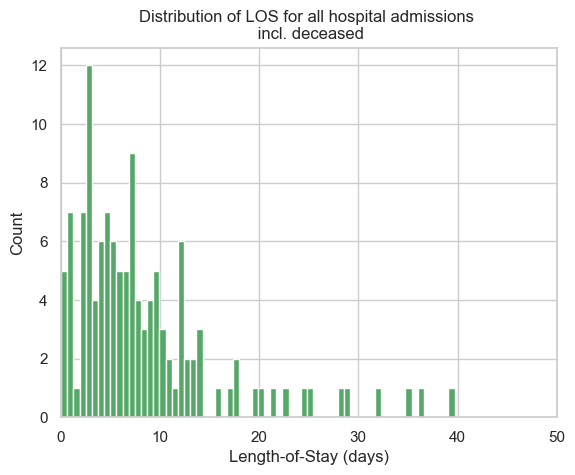

In [101]:
# Plot LOS Distribution
plt.hist(ADMISSIONS_df['LOS'], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for all hospital admissions \n incl. deceased')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [102]:
# Pre-emptively drop some columns that I don't need anymore
ADMISSIONS_df.drop(columns=['DISCHTIME', 'ROW_ID', 
                'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                'HAS_CHARTEVENTS_DATA'], inplace=True)

In [103]:
# Mark admissions where patients died in boolean column
ADMISSIONS_df['DECEASED'] = ADMISSIONS_df['DEATHTIME'].notnull().map({True:1, False:0})

In [104]:
print("{} of {} patients died in the hospital".format(ADMISSIONS_df['DECEASED'].sum(), 
ADMISSIONS_df['SUBJECT_ID'].nunique()))

40 of 97 patients died in the hospital


In [105]:
# Look at statistics less admissions resulting in death
ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0].describe()

count     86.000000
mean       9.910578
std       14.154175
min        0.980556
25%        4.126042
50%        7.146181
75%       10.520486
max      123.984722
Name: LOS, dtype: float64

In [106]:
# Hospital LOS metrics for later comparison
actual_mean_los = ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0].mean() 
actual_median_los = ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0].median() 

print(actual_mean_los)
print(actual_median_los)

9.910578165374677
7.1461805555555555


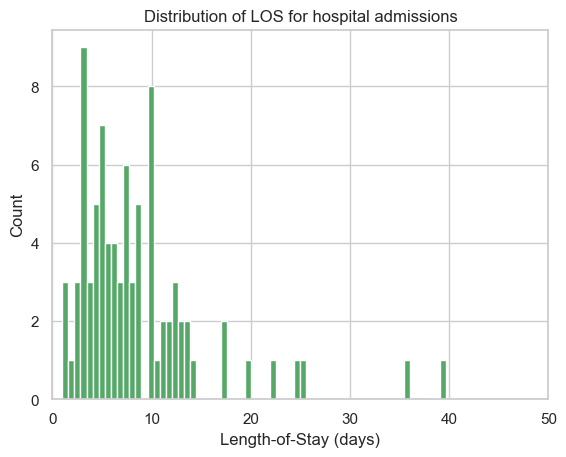

In [107]:
plt.hist(ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0], bins=200, color = '#55a868')
plt.xlim(0, 50)
plt.title('Distribution of LOS for hospital admissions')
plt.ylabel('Count')
plt.xlabel('Length-of-Stay (days)')
plt.tick_params(top=False, right=False) 
plt.show();

In [108]:
ADMISSIONS_df['ETHNICITY'].value_counts()

ETHNICITY
WHITE                                                       84
HISPANIC/LATINO - PUERTO RICAN                              15
UNKNOWN/NOT SPECIFIED                                       10
BLACK/AFRICAN AMERICAN                                       7
OTHER                                                        3
ASIAN                                                        2
HISPANIC OR LATINO                                           2
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE     2
UNABLE TO OBTAIN                                             1
Name: count, dtype: int64

In [109]:
ADMISSIONS_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
ADMISSIONS_df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
ADMISSIONS_df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
ADMISSIONS_df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
ADMISSIONS_df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                         'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
ADMISSIONS_df['ETHNICITY'].loc[~ADMISSIONS_df['ETHNICITY'].isin(ADMISSIONS_df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'
ADMISSIONS_df['ETHNICITY'].value_counts()

ETHNICITY
WHITE                     84
HISPANIC/LATINO           17
OTHER/UNKNOWN             16
BLACK/AFRICAN AMERICAN     7
ASIAN                      2
Name: count, dtype: int64

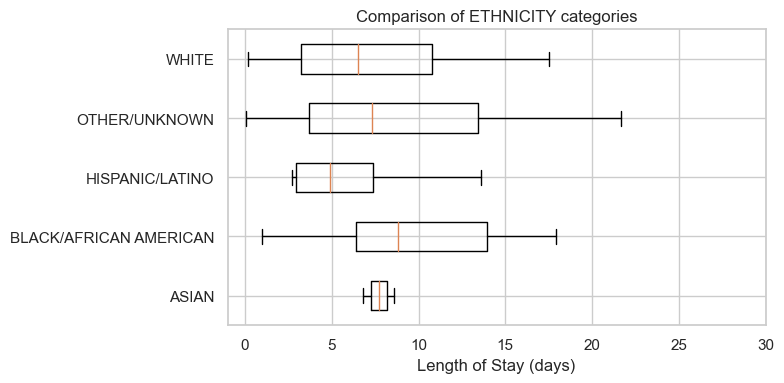

In [110]:
# Re-usable plotting function
def plot_los_groupby(variable, size=(7,4)):
    ''' 
    Plot Median LOS by df categorical series name 
    '''
    results = ADMISSIONS_df[[variable, 'LOS']].groupby(variable).median().reset_index()
    values = list(results['LOS'].values)
    labels = list(results[variable].values)

    fig, ax = plt.subplots(figsize=size)
    ind = range(len(results))
    ax.barh(ind, values, align='center', height=0.6, color = '#55a868', alpha=0.8)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Median Length of Stay (days)')
    ax.tick_params(left=False, top=False, right=False) 
    ax.set_title('Comparison of {} labels'.format(variable))
    
    plt.tight_layout()
    plt.show();
    
# Re-usable boxplot function
def boxplot_los_groupby(variable, los_range=(-1, 30), size=(8,4)):
    ''' 
    Boxplot of LOS by df categorical series name 
    '''
    results = ADMISSIONS_df[[variable, 'LOS']].groupby(variable).median().reset_index()

    categories = results[variable].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(ADMISSIONS_df['LOS'].loc[ADMISSIONS_df[variable]==cat].values)

    fig, ax = plt.subplots(figsize=size)
    ax.boxplot(hist_data, 0, '', vert=False)
    ax.set_xlim(los_range)
    ax.set_yticklabels(categories)
    ax.set_xlabel('Length of Stay (days)')
    ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format(variable))
    plt.tight_layout()
    plt.show();

boxplot_los_groupby('ETHNICITY', los_range=(-1, 30))

In [111]:
ADMISSIONS_df['RELIGION'].value_counts()

RELIGION
CATHOLIC               59
UNOBTAINABLE           19
NOT SPECIFIED          18
PROTESTANT QUAKER       9
JEWISH                  9
OTHER                   4
CHRISTIAN SCIENTIST     3
MUSLIM                  2
BUDDHIST                1
ROMANIAN EAST. ORTH     1
Name: count, dtype: int64

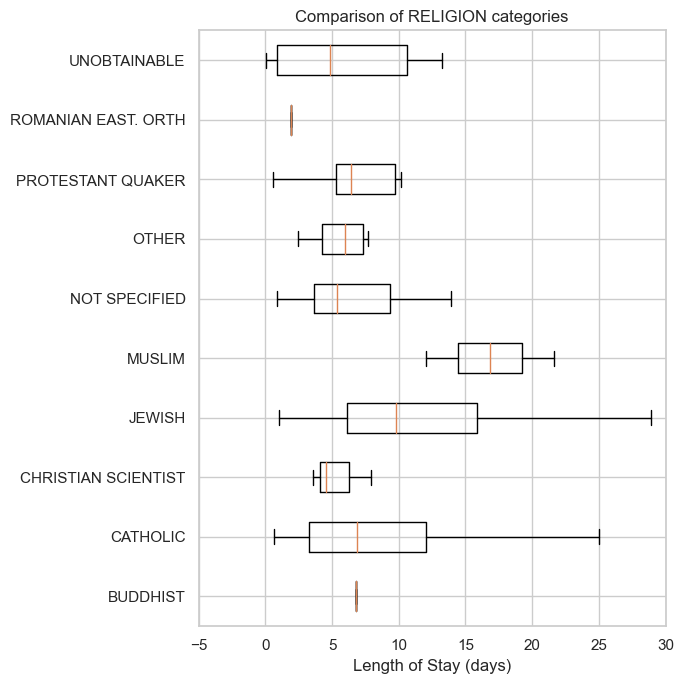

In [112]:
boxplot_los_groupby('RELIGION', los_range=(-5, 30), size=(7, 7))

In [113]:
# Reduce categories to terms of religious or not
# I tested with and without category reduction, with little change in R2 score
ADMISSIONS_df['RELIGION'].loc[~ADMISSIONS_df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

print(ADMISSIONS_df['RELIGION'].value_counts())
print(ADMISSIONS_df['RELIGION'].value_counts()[0]/len(ADMISSIONS_df['RELIGION']))
print(ADMISSIONS_df['RELIGION'].value_counts()[1]/len(ADMISSIONS_df['RELIGION']))
print(ADMISSIONS_df['RELIGION'].value_counts()[2]/len(ADMISSIONS_df['RELIGION']))

RELIGION
RELIGIOUS        89
UNOBTAINABLE     19
NOT SPECIFIED    18
Name: count, dtype: int64
0.7063492063492064
0.15079365079365079
0.14285714285714285


C:\Users\Sandeep.Mailarkar\AppData\Local\Temp\ipykernel_11440\2944388743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ADMISSIONS_df['RELIGION'].loc[~ADMISSIONS_df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'


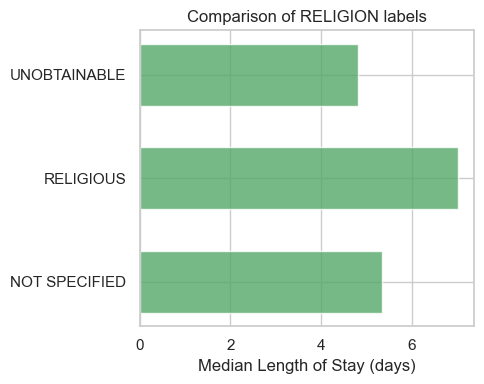

In [114]:
# Look at median LOS for groups
plot_los_groupby('RELIGION', size=(5,4))

In [115]:
ADMISSIONS_df['ADMISSION_TYPE'].value_counts()

ADMISSION_TYPE
EMERGENCY    118
ELECTIVE       7
URGENT         1
Name: count, dtype: int64

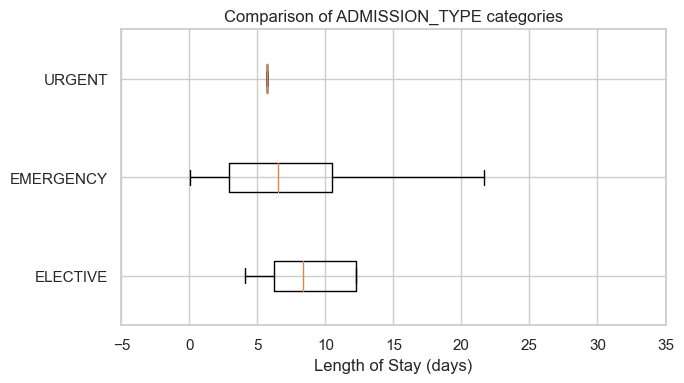

In [116]:
boxplot_los_groupby('ADMISSION_TYPE', los_range=(-5, 35), size=(7, 4))

In [117]:
ADMISSIONS_df['INSURANCE'].value_counts()

INSURANCE
Medicare      96
Private       23
Medicaid       6
Government     1
Name: count, dtype: int64

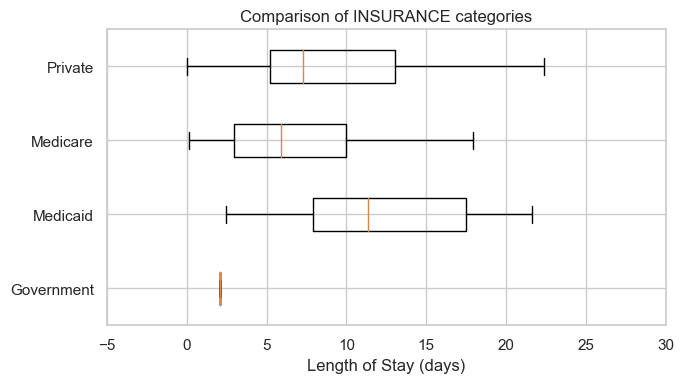

In [118]:
boxplot_los_groupby('INSURANCE', los_range=(-5, 30), size=(7, 4))

In [119]:
ADMISSIONS_df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              57
SINGLE               26
None                 16
WIDOWED              15
DIVORCED              6
UNKNOWN (DEFAULT)     5
SEPARATED             1
Name: count, dtype: int64

In [120]:
# Fix NaNs and file under 'UNKNOWN'
ADMISSIONS_df['MARITAL_STATUS'] = ADMISSIONS_df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
ADMISSIONS_df['MARITAL_STATUS'].value_counts(dropna=False)

MARITAL_STATUS
MARRIED              57
SINGLE               26
UNKNOWN (DEFAULT)    21
WIDOWED              15
DIVORCED              6
SEPARATED             1
Name: count, dtype: int64

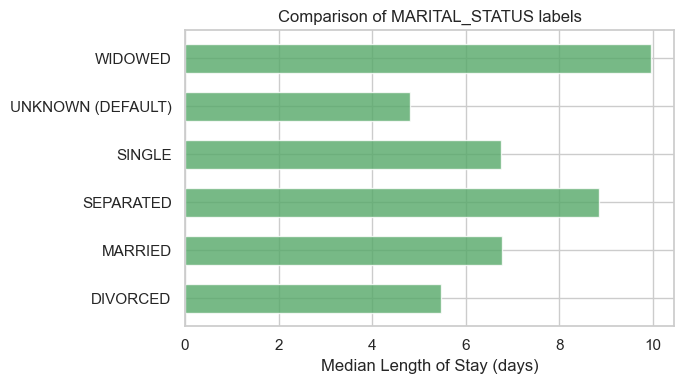

In [121]:
plot_los_groupby('MARITAL_STATUS')

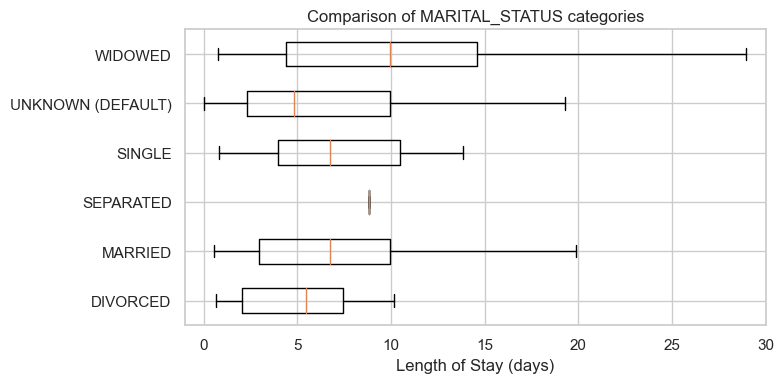

In [122]:
boxplot_los_groupby('MARITAL_STATUS')

In [123]:
DIAGNOSES_ICD_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ROW_ID       1761 non-null   int32 
 1   SUBJECT_ID   1761 non-null   int32 
 2   HADM_ID      1761 non-null   int32 
 3   SEQ_NUM      1761 non-null   int8  
 4   ICD9_CODE    1761 non-null   object
 5   ICD_VERSION  1761 non-null   int8  
dtypes: int32(3), int8(2), object(1)
memory usage: 38.0+ KB


In [124]:
print('There are {} unique ICD9 codes in this dataset.'.format(DIAGNOSES_ICD_df['ICD9_CODE'].value_counts().count()))

There are 580 unique ICD9 codes in this dataset.


In [125]:
'''001–139: infectious and parasitic diseases
140–239: neoplasms
240–279: endocrine, nutritional and metabolic diseases, and immunity disorders
280–289: diseases of the blood and blood-forming organs
290–319: mental disorders
320–389: diseases of the nervous system and sense organs
390–459: diseases of the circulatory system
460–519: diseases of the respiratory system
520–579: diseases of the digestive system
580–629: diseases of the genitourinary system
630–679: complications of pregnancy, childbirth, and the puerperium
680–709: diseases of the skin and subcutaneous tissue
710–739: diseases of the musculoskeletal system and connective tissue
740–759: congenital anomalies
760–779: certain conditions originating in the perinatal period
780–799: symptoms, signs, and ill-defined conditions
800–999: injury and poisoning
E and V codes: external causes of injury and supplemental classification, using 999 as placeholder even though it overlaps with complications of medical care'''

# Filter out E and V codes since processing will be done on the numeric first 3 values

DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['ICD9_CODE']
DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'][~DIAGNOSES_ICD_df['recode'].str.contains("[a-zA-Z]").fillna(False)]
DIAGNOSES_ICD_df['recode'].fillna(value='999', inplace=True)

In [126]:
# https://stackoverflow.com/questions/46168450/replace-specific-range-of-values-in-data-frame-pandas
DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'].str.slice(start=0, stop=3, step=1)
DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'].astype(int)

In [127]:
# ICD-9 Main Category ranges
icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
               (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
               (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

# Associated category names
diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
             4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
             8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
             12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
             16: 'injury', 17: 'misc'}

# Re-code in terms of integer
for num, cat_range in enumerate(icd9_ranges):
    DIAGNOSES_ICD_df['recode'] = np.where(DIAGNOSES_ICD_df['recode'].between(cat_range[0],cat_range[1]), 
            num, DIAGNOSES_ICD_df['recode'])
    
# Convert integer to category name using diag_dict
DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode']
DIAGNOSES_ICD_df['cat'] = DIAGNOSES_ICD_df['recode'].replace(diag_dict)


In [128]:
# Verify
DIAGNOSES_ICD_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,ICD_VERSION,recode,cat
0,112344,10006,142345,1,99591,9,16,injury
1,112345,10006,142345,2,99662,9,16,injury
2,112346,10006,142345,3,5672,9,8,digestive
3,112347,10006,142345,4,40391,9,6,circulatory
4,112348,10006,142345,5,42731,9,6,circulatory


In [129]:
# Create list of diagnoses for each admission
hadm_list = DIAGNOSES_ICD_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
hadm_list.head()

,HADM_ID,cat
0,100375,"[nervous, genitourinary, genitourinary, endocr..."
1,100969,"[circulatory, nervous, respiratory, respirator..."
2,101361,"[injury, respiratory, respiratory, respiratory..."
3,102203,"[digestive, genitourinary, misc, endocrine, di..."
4,103379,"[nervous, misc, respiratory, injury, neoplasms..."


In [130]:
# Convert diagnoses list into hospital admission-item matrix
#hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).sum(level=0)
#hadm_item.head()

hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,0,2,0,0,2,2,0,1,0,1,0,0,1,0,0,0
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0
2,1,2,0,1,2,1,0,11,1,0,0,0,3,0,5,4
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0
4,1,1,0,0,1,0,0,2,0,1,0,3,1,0,1,0


In [131]:
# Join back with HADM_ID, will merge with main admissions DF later
#hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")
#hadm_item.head()

hadm_item = hadm_item.join(hadm_list[['HADM_ID']], how="outer")
hadm_item.head()

,blood,circulatory,congenital,digestive,endocrine,genitourinary,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,HADM_ID
0,0,2,0,0,2,2,0,1,0,1,0,0,1,0,0,0,100375
1,0,4,0,0,1,0,0,0,1,0,0,0,1,0,3,0,100969
2,1,2,0,1,2,1,0,11,1,0,0,0,3,0,5,4,101361
3,0,0,0,4,3,1,0,1,1,1,0,0,0,0,0,0,102203
4,1,1,0,0,1,0,0,2,0,1,0,3,1,0,1,0,103379


In [132]:
# Merge with main admissions df
ADMISSIONS_df = ADMISSIONS_df.merge(hadm_item, how='inner', on='HADM_ID')

In [133]:
ADMISSIONS_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,infectious,injury,mental,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin
0,10006,142345,2164-10-23 21:09:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,None,RELIGIOUS,...,0,6,1,1,0,0,1,0,0,0
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,None,RELIGIOUS,...,0,0,1,0,0,0,0,0,0,2
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,RELIGIOUS,...,0,0,0,1,0,1,1,0,1,0
3,10017,199207,2149-05-26 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,RELIGIOUS,...,0,7,0,0,0,0,0,0,2,0
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,RELIGIOUS,...,0,1,1,1,1,0,1,0,2,0


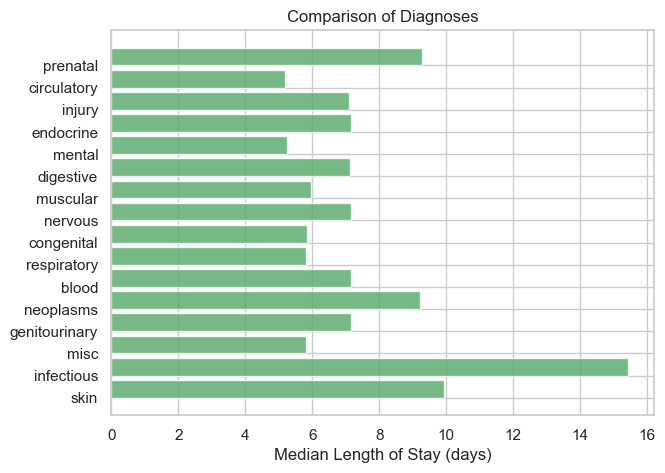

In [134]:
# Look at the median LOS by diagnosis category
diag_cat_list = ['skin', 'infectious',  'misc', 'genitourinary', 'neoplasms', 'blood', 'respiratory', 
                  'congenital','nervous', 'muscular', 'digestive', 'mental', 'endocrine', 'injury',
                 'circulatory', 'prenatal']

results = []
for variable in diag_cat_list:
    results.append(ADMISSIONS_df[[variable, 'LOS']].groupby(variable).median().reset_index().values[1][1])

sns.set(style="whitegrid")
#sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(7,5))
ind = range(len(results))
ax.barh(ind, results, align='edge', color = '#55a868', alpha=0.8)
ax.set_yticks(ind)
ax.set_yticklabels(diag_cat_list)
ax.set_xlabel('Median Length of Stay (days)')
ax.tick_params(left=False, right=False, top=False) 
ax.set_title('Comparison of Diagnoses'.format(variable))
plt.show();

In [135]:
PATIENTS_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,9467,10006,F,2094-03-05,2165-08-12,2165-08-12,2165-08-12,1
1,9472,10011,F,2090-06-05,2126-08-28,2126-08-28,NaT,1
2,9474,10013,F,2038-09-03,2125-10-07,2125-10-07,2125-10-07,1
3,9478,10017,F,2075-09-21,2152-09-12,NaT,2152-09-12,1
4,9479,10019,M,2114-06-20,2163-05-15,2163-05-15,2163-05-15,1


In [136]:
PATIENTS_df['GENDER'].value_counts()

GENDER
F    55
M    45
Name: count, dtype: int64

In [137]:
# Convert to datetime type
PATIENTS_df['DOB'] = pd.to_datetime(PATIENTS_df['DOB'])

In [138]:
PATIENTS_df = PATIENTS_df[['SUBJECT_ID', 'DOB', 'GENDER']]
PATIENTS_df.head()


,SUBJECT_ID,DOB,GENDER
0,10006,2094-03-05,F
1,10011,2090-06-05,F
2,10013,2038-09-03,F
3,10017,2075-09-21,F
4,10019,2114-06-20,M


In [139]:
ADMISSIONS_df = ADMISSIONS_df.merge(PATIENTS_df, how='inner', on='SUBJECT_ID')

In [140]:
# Find the first admission time for each patient
df_age_min = ADMISSIONS_df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
df_age_min.head()

,SUBJECT_ID,ADMIT_MIN
0,10006,2164-10-23 21:09:00
1,10011,2126-08-14 22:32:00
2,10013,2125-10-04 23:36:00
3,10017,2149-05-26 17:19:00
4,10019,2163-05-14 20:43:00


In [141]:
ADMISSIONS_df= ADMISSIONS_df.merge(df_age_min, how='outer', on='SUBJECT_ID')

In [142]:
# Verify merge
ADMISSIONS_df.head() 

,SUBJECT_ID,HADM_ID,ADMITTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,...,misc,muscular,neoplasms,nervous,prenatal,respiratory,skin,DOB,GENDER,ADMIT_MIN
0,10006,142345,2164-10-23 21:09:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,None,RELIGIOUS,...,1,0,0,1,0,0,0,2094-03-05,F,2164-10-23 21:09:00
1,10011,105331,2126-08-14 22:32:00,2126-08-28 18:59:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Private,None,RELIGIOUS,...,0,0,0,0,0,0,2,2090-06-05,F,2126-08-14 22:32:00
2,10013,165520,2125-10-04 23:36:00,2125-10-07 15:13:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,RELIGIOUS,...,1,0,1,1,0,1,0,2038-09-03,F,2125-10-04 23:36:00
3,10017,199207,2149-05-26 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,None,RELIGIOUS,...,0,0,0,0,0,2,0,2075-09-21,F,2149-05-26 17:19:00
4,10019,177759,2163-05-14 20:43:00,2163-05-15 12:00:00,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,DEAD/EXPIRED,Medicare,None,RELIGIOUS,...,1,1,0,1,0,2,0,2114-06-20,M,2163-05-14 20:43:00


In [143]:
# Convert date of birth and admission date to Unix timestamps (seconds since epoch)

ADMISSIONS_df['DOB_timestamp'] = ADMISSIONS_df['DOB'].astype(np.int64) // 10**9

ADMISSIONS_df['ADMIT_MIN_timestamp'] = ADMISSIONS_df['ADMIT_MIN'].astype(np.int64) // 10**9

 

# Calculate the age in seconds

ADMISSIONS_df['age_seconds'] = ADMISSIONS_df['ADMIT_MIN_timestamp'] - ADMISSIONS_df['DOB_timestamp']

 

# Calculate age in years by dividing age in seconds by the number of seconds in a year

ADMISSIONS_df['age'] = ADMISSIONS_df['age_seconds'] / (365.25 * 24 * 60 * 60)

 

# Handle negative age values by setting them to a default value (e.g., 90)

ADMISSIONS_df['age'] = np.where(ADMISSIONS_df['age'] < 0, 90, ADMISSIONS_df['age'])

 

# Handle the case where age becomes -0 (if both dates are exactly the same)

ADMISSIONS_df['age'] = np.where(ADMISSIONS_df['age'] == -0, 0, ADMISSIONS_df['age'])

 

# Check for and handle any NaN values in the 'age' column

ADMISSIONS_df['age'].fillna(0, inplace=True)

 

# Check if there are any null values left in the 'age' column

ADMISSIONS_df['age'].isnull().sum()

 

# Remove intermediate columns (Unix timestamps and age in seconds)

#ADMISSIONS_df.drop(['DOB_timestamp', 'ADMIT_MIN_timestamp', 'age_seconds'], axis=1, inplace=True)





ADMISSIONS_df['age'].isnull().sum()

0

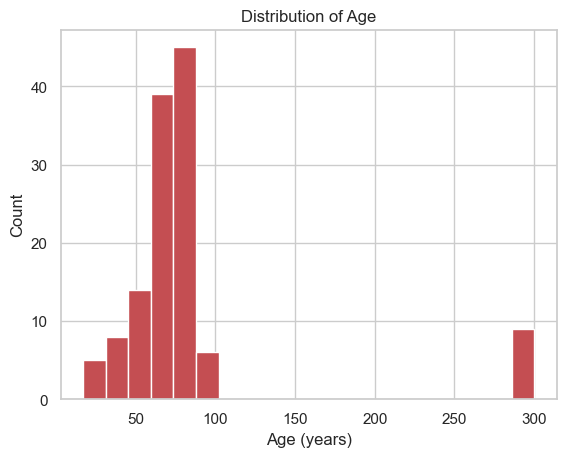

In [144]:
# Note that no ‘middle’ patients show up - this reflects the fact that does not contain data from pediatric patients.
plt.hist(ADMISSIONS_df['age'], bins=20, color='#c44e52')
plt.ylabel('Count')
plt.xlabel('Age (years)')
plt.title('Distribution of Age')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

(1.0, 50.0)

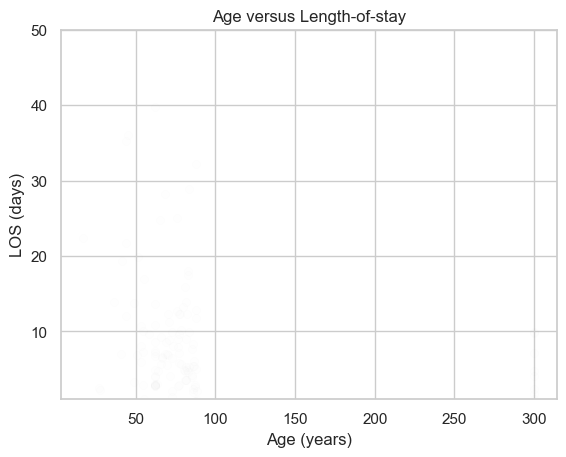

In [145]:
plt.scatter(ADMISSIONS_df['age'], ADMISSIONS_df['LOS'], alpha=0.005)
#plt.yscale('sqrt')
plt.ylabel('LOS (days)')
plt.xlabel('Age (years)')
plt.title('Age versus Length-of-stay')
plt.ylim(1, 50)

In [146]:
# https://en.wikipedia.org/wiki/List_of_ICD-9_codes
age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
for num, cat_range in enumerate(age_ranges):
    ADMISSIONS_df['age'] = np.where(ADMISSIONS_df['age'].between(cat_range[0],cat_range[1]), 
            num, ADMISSIONS_df['age'])
    
age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
ADMISSIONS_df['age'] = ADMISSIONS_df['age'].replace(age_dict)
ADMISSIONS_df.age.value_counts()

age
senior                91
middle_adult          21
young_adult            5
299.9966803559206      2
299.9953969883641      1
299.9964560042589      1
299.99675260476084     1
299.99647121454103     1
299.99620693588867     1
299.9960529317819      1
299.9968609780211      1
Name: count, dtype: int64

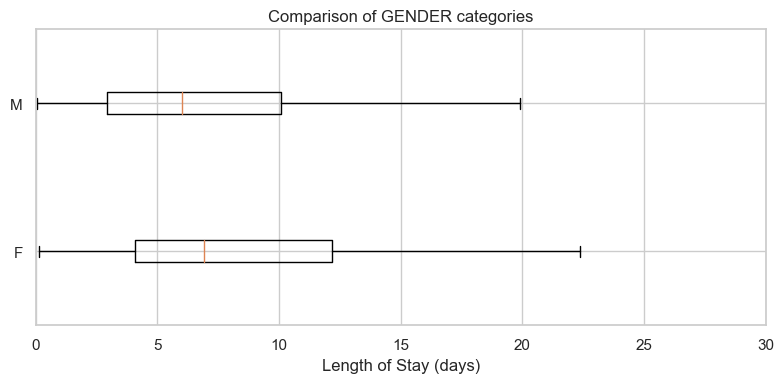

In [147]:
boxplot_los_groupby('GENDER', los_range=(0, 30))
ADMISSIONS_df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)

In [148]:
# Intensive Care Unit (ICU) for each admission to hospital
ICUSTAYS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ROW_ID          136 non-null    int32         
 1   SUBJECT_ID      136 non-null    int32         
 2   HADM_ID         136 non-null    int32         
 3   ICUSTAY_ID      136 non-null    int32         
 4   DBSOURCE        136 non-null    object        
 5   FIRST_CAREUNIT  136 non-null    object        
 6   LAST_CAREUNIT   136 non-null    object        
 7   FIRST_WARDID    136 non-null    int8          
 8   LAST_WARDID     136 non-null    int8          
 9   INTIME          136 non-null    datetime64[ns]
 10  OUTTIME         136 non-null    datetime64[ns]
 11  LOS             136 non-null    float64       
dtypes: datetime64[ns](2), float64(1), int32(4), int8(2), object(3)
memory usage: 8.9+ KB


In [149]:
ICUSTAYS_df['HADM_ID'].nunique()

129

In [150]:
numeric_columns = ICUSTAYS_df.select_dtypes(include=[np.number])  # Select numeric columns
median_values = numeric_columns.groupby(ICUSTAYS_df['FIRST_CAREUNIT']).median()
median_values.groupby('FIRST_CAREUNIT').median()

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,FIRST_WARDID,LAST_WARDID,LOS
FIRST_CAREUNIT,,,,,,,
CCU,41491.0,40503.0,154156.0,256542.0,7.0,7.0,2.8833
CSRU,12815.5,10079.0,156977.5,254860.0,13.0,14.5,2.0840
MICU,41416.0,40286.0,161765.0,251281.0,50.0,50.0,1.9252
SICU,41974.0,41976.0,142633.0,246080.0,57.0,57.0,2.4056
TSICU,41532.0,40612.0,160442.0,262670.0,14.0,14.0,1.2762


In [151]:
# Based on above statistics, reduce to just ICU and NICU groups
ICUSTAYS_df['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)

In [152]:
ICUSTAYS_df['cat'] = ICUSTAYS_df['FIRST_CAREUNIT']
icu_list = ICUSTAYS_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
icu_list.head()

,HADM_ID,cat
0,100375,[ICU]
1,100969,[ICU]
2,101361,[ICU]
3,102203,[ICU]
4,103379,[ICU]


In [153]:
ICUSTAYS_df['FIRST_CAREUNIT'].value_counts()

FIRST_CAREUNIT
ICU    136
Name: count, dtype: int64

In [154]:
# Create admission-ICU matrix
#icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
#icu_item[icu_item >= 1] = 1
#icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
#icu_item.head()

icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack().reset_index(level=1, drop=True))

icu_item = icu_item.groupby(icu_item.index).sum()

icu_item = icu_item.clip(upper=1)

icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")

icu_item.head()

,ICU,HADM_ID
0,1,100375
1,1,100969
2,1,101361
3,1,102203
4,1,103379


In [155]:
print("Number of admissions to ICU {}.".format(icu_item.ICU.sum()))
#print("Number of admissions to NICU {}.".format(icu_item.NICU.sum()))

Number of admissions to ICU 129.


In [156]:
# Merge ICU data with main dataFrame
ADMISSIONS_df = ADMISSIONS_df.merge(icu_item, how='outer', on='HADM_ID')

In [157]:
# Replace NaNs with 0
ADMISSIONS_df['ICU'].fillna(value=0, inplace=True)
#ADMISSIONS_df['NICU'].fillna(value=0, inplace=True)

In [158]:
# Verify NaN fix
print(ADMISSIONS_df.ICU.value_counts(dropna=False))
#print(ADMISSIONS_df.NICU.value_counts(dropna=False))

ICU
1    129
Name: count, dtype: int64


In [159]:
ADMISSIONS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           126 non-null    float64       
 1   HADM_ID              129 non-null    int32         
 2   ADMITTIME            126 non-null    datetime64[ns]
 3   DEATHTIME            40 non-null     datetime64[ns]
 4   ADMISSION_TYPE       126 non-null    object        
 5   ADMISSION_LOCATION   126 non-null    object        
 6   DISCHARGE_LOCATION   126 non-null    object        
 7   INSURANCE            126 non-null    object        
 8   LANGUAGE             80 non-null     object        
 9   RELIGION             126 non-null    object        
 10  MARITAL_STATUS       126 non-null    object        
 11  ETHNICITY            126 non-null    object        
 12  DIAGNOSIS            126 non-null    object        
 13  LOS                  126 non-null  

In [160]:
# Remove deceased persons as they will skew LOS result
ADMISSIONS_df = ADMISSIONS_df[ADMISSIONS_df['DECEASED'] == 0]

# Remove LOS with negative number, likely entry form error
ADMISSIONS_df = ADMISSIONS_df[ADMISSIONS_df['LOS'] > 0]

In [161]:
# Drop unused or no longer needed columns
ADMISSIONS_df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME',
                 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED',  'DEATHTIME'], inplace=True)

ADMISSIONS_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 125
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ADMISSION_TYPE       86 non-null     object 
 1   ADMISSION_LOCATION   86 non-null     object 
 2   DISCHARGE_LOCATION   86 non-null     object 
 3   INSURANCE            86 non-null     object 
 4   LANGUAGE             60 non-null     object 
 5   RELIGION             86 non-null     object 
 6   MARITAL_STATUS       86 non-null     object 
 7   ETHNICITY            86 non-null     object 
 8   LOS                  86 non-null     float64
 9   blood                86 non-null     float64
 10  circulatory          86 non-null     float64
 11  congenital           86 non-null     float64
 12  digestive            86 non-null     float64
 13  endocrine            86 non-null     float64
 14  genitourinary        86 non-null     float64
 15  infectious           86 non-null     float64
 

In [162]:
# Create dummy columns for categorical variables
prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR', 'RELIGION']
dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
             'ETHNICITY', 'age', 'MARITAL_STATUS', 'RELIGION']
ADMISSIONS_df = pd.get_dummies(ADMISSIONS_df, prefix=prefix_cols, columns=dummy_cols)
ADMISSIONS_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 125
Data columns (total 55 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ADMISSION_LOCATION          86 non-null     object 
 1   DISCHARGE_LOCATION          86 non-null     object 
 2   LANGUAGE                    60 non-null     object 
 3   LOS                         86 non-null     float64
 4   blood                       86 non-null     float64
 5   circulatory                 86 non-null     float64
 6   congenital                  86 non-null     float64
 7   digestive                   86 non-null     float64
 8   endocrine                   86 non-null     float64
 9   genitourinary               86 non-null     float64
 10  infectious                  86 non-null     float64
 11  injury                      86 non-null     float64
 12  mental                      86 non-null     float64
 13  misc                        86 non-null  

In [163]:
ADMISSIONS_df.head()

,ADMISSION_LOCATION,DISCHARGE_LOCATION,LANGUAGE,LOS,blood,circulatory,congenital,digestive,endocrine,genitourinary,...,AGE_young_adult,MAR_DIVORCED,MAR_MARRIED,MAR_SEPARATED,MAR_SINGLE,MAR_UNKNOWN (DEFAULT),MAR_WIDOWED,RELIGION_NOT SPECIFIED,RELIGION_RELIGIOUS,RELIGION_UNOBTAINABLE
0,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,None,8.837500,2.0,6.0,0.0,2.0,2.0,0.0,...,False,False,False,True,False,False,False,False,True,False
3,EMERGENCY ROOM ADMIT,SNF,None,8.057639,1.0,2.0,0.0,0.0,2.0,0.0,...,False,True,False,False,False,False,False,False,True,False
5,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,None,7.170833,1.0,2.0,0.0,0.0,1.0,1.0,...,False,False,False,False,False,True,False,False,True,False
6,PHYS REFERRAL/NORMAL DELI,SNF,None,12.281250,0.0,7.0,0.0,1.0,1.0,1.0,...,False,False,True,False,False,False,False,False,True,False
7,EMERGENCY ROOM ADMIT,SNF,None,10.146528,1.0,5.0,0.0,2.0,0.0,2.0,...,False,True,False,False,False,False,False,False,True,False


In [164]:
'''def los_cleanup(adm_csv='ADMISSIONS.csv', patients_csv='PATIENTS.csv',
                      diagcode_csv='DIAGNOSES_ICD.csv', icu_csv='ICUSTAYS.csv',
                      verbose=True):'''


# Establish a Snowflake connection using your credentials

connection_parameters = {

    "account": "wqkmqve-hh76255",

    "user": "SANDEEPMAILARKAR",

    "password": "Parkar@1234",

    "role": "ACCOUNTADMIN",

    "warehouse": "COMPUTE_WH",

    "database": "PREVENTIVE_HEALTHCARE",

    "schema": "GOLD_LOS"

}

 
    
    

conn = snowflake.connector.connect(**connection_parameters)

cursor = conn.cursor()

 

def los_cleanup(cursor, verbose=True):

    # Query Snowflake tables to load data

    ADMISSIONS_query = "SELECT * FROM ADMISSIONS"

    PATIENTS_query = "SELECT * FROM PATIENTS"

    DIAGNOSES_ICD_query = "SELECT * FROM DIAGNOSES_ICD"

    ICUSTAYS_query = "SELECT * FROM ICUSTAYS"

 

    ADMISSIONS_df = pd.read_sql(ADMISSIONS_query, conn)

    PATIENTS_df = pd.read_sql(PATIENTS_query, conn)

    DIAGNOSES_ICD_df = pd.read_sql(DIAGNOSES_ICD_query, conn)

    ICUSTAYS_df = pd.read_sql(ICUSTAYS_query, conn)

    
 

    if verbose:

        print('(1/5) Completed Snowflake table imports')
        
  # Feature Engineering for Length of Stay (LOS) target variable
    # Convert admission and discharge times to datatime type
    ADMISSIONS_df['ADMITTIME'] = pd.to_datetime(ADMISSIONS_df['ADMITTIME'])
    ADMISSIONS_df['DISCHTIME'] = pd.to_datetime(ADMISSIONS_df['DISCHTIME'])
    # Convert timedelta type into float 'days', 86400 seconds in a day
    ADMISSIONS_df['LOS'] = (ADMISSIONS_df['DISCHTIME'] - ADMISSIONS_df['ADMITTIME']).dt.total_seconds()/86400
    
    # Drop columns that are not needed for next steps
    ADMISSIONS_df.drop(columns=['DISCHTIME', 'ROW_ID', 
                    'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG',
                    'HAS_CHARTEVENTS_DATA'], inplace=True)
    
    # Track patients who died at the hospital by admission event
    ADMISSIONS_df['DECEASED'] = ADMISSIONS_df['DEATHTIME'].notnull().map({True:1, False:0})
    
    # Hospital LOS metrics
    actual_mean_los = ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0].mean() 
    actual_median_los = ADMISSIONS_df['LOS'].loc[ADMISSIONS_df['DECEASED'] == 0].median() 
    
    # Compress the number of ethnicity categories
    ADMISSIONS_df['ETHNICITY'].replace(regex=r'^ASIAN\D*', value='ASIAN', inplace=True)
    ADMISSIONS_df['ETHNICITY'].replace(regex=r'^WHITE\D*', value='WHITE', inplace=True)
    ADMISSIONS_df['ETHNICITY'].replace(regex=r'^HISPANIC\D*', value='HISPANIC/LATINO', inplace=True)
    ADMISSIONS_df['ETHNICITY'].replace(regex=r'^BLACK\D*', value='BLACK/AFRICAN AMERICAN', inplace=True)
    ADMISSIONS_df['ETHNICITY'].replace(['UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER', 
                             'UNKNOWN/NOT SPECIFIED'], value='OTHER/UNKNOWN', inplace=True)
    ADMISSIONS_df['ETHNICITY'].loc[~ADMISSIONS_df['ETHNICITY'].isin(ADMISSIONS_df['ETHNICITY'].value_counts().nlargest(5).index.tolist())] = 'OTHER/UNKNOWN'

    # Reduce categories to terms of religious or not
    ADMISSIONS_df['RELIGION'].loc[~ADMISSIONS_df['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'

    # Re-categorize NaNs into 'Unknown'
    ADMISSIONS_df['MARITAL_STATUS'] = ADMISSIONS_df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
    
    if verbose: 
        print('(2/5) Completed ADMISSIONS.csv cleanup and feature Engineering.')
        
    # Feature Engineering for ICD9 code categories
    # Filter out E and V codes since processing will be done on the numeric first 3 values
    DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['ICD9_CODE']
    DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'][~DIAGNOSES_ICD_df['recode'].str.contains("[a-zA-Z]").fillna(False)]
    DIAGNOSES_ICD_df['recode'].fillna(value='999', inplace=True)
    DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'].str.slice(start=0, stop=3, step=1)
    DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode'].astype(int)
    
    # ICD-9 Main Category ranges
    icd9_ranges = [(1, 140), (140, 240), (240, 280), (280, 290), (290, 320), (320, 390), 
                   (390, 460), (460, 520), (520, 580), (580, 630), (630, 680), (680, 710),
                   (710, 740), (740, 760), (760, 780), (780, 800), (800, 1000), (1000, 2000)]

    # Associated category names
    diag_dict = {0: 'infectious', 1: 'neoplasms', 2: 'endocrine', 3: 'blood',
                 4: 'mental', 5: 'nervous', 6: 'circulatory', 7: 'respiratory',
                 8: 'digestive', 9: 'genitourinary', 10: 'pregnancy', 11: 'skin', 
                 12: 'muscular', 13: 'congenital', 14: 'prenatal', 15: 'misc',
                 16: 'injury', 17: 'misc'}

    # Re-code in terms of integer
    for num, cat_range in enumerate(icd9_ranges):
        DIAGNOSES_ICD_df['recode'] = np.where(DIAGNOSES_ICD_df['recode'].between(cat_range[0],cat_range[1]), 
                num, DIAGNOSES_ICD_df['recode'])

    # Convert integer to category name using diag_dict
    DIAGNOSES_ICD_df['recode'] = DIAGNOSES_ICD_df['recode']
    DIAGNOSES_ICD_df['cat'] = DIAGNOSES_ICD_df['recode'].replace(diag_dict)
    
    # Create list of diagnoses for each admission
    hadm_list = DIAGNOSES_ICD_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
    
    # Convert diagnoses list into hospital admission-item matrix
    hadm_item = pd.get_dummies(hadm_list['cat'].apply(pd.Series).stack()).groupby(level=0).sum()
    
    # Join back with HADM_ID, will merge with main admissions DF later
    hadm_item = hadm_item.join(hadm_list['HADM_ID'], how="outer")

    # Merge with main admissions df
    ADMISSIONS_df = ADMISSIONS_df.merge(hadm_item, how='inner', on='HADM_ID')
    
    if verbose: 
        print('(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature Engineering.')
    
    # Feature Engineering for Age and Gender
    # Convert to datetime type
    PATIENTS_df['DOB'] = pd.to_datetime(PATIENTS_df['DOB'])
    PATIENTS_df = PATIENTS_df[['SUBJECT_ID', 'DOB', 'GENDER']]
    ADMISSIONS_df = ADMISSIONS_df.merge(PATIENTS_df, how='inner', on='SUBJECT_ID')
    
    # Find the first admission time for each patient
    df_age_min = ADMISSIONS_df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
    df_age_min.columns = ['SUBJECT_ID', 'ADMIT_MIN']
    ADMISSIONS_df = ADMISSIONS_df.merge(df_age_min, how='outer', on='SUBJECT_ID')
    
    # Age is decode by finding the difference in admission date and date of birth
    ADMISSIONS_df['age'] = (ADMISSIONS_df['ADMIT_MIN'].dt.year - ADMISSIONS_df['DOB'].dt.year)
    ADMISSIONS_df['age'] = ADMISSIONS_df['age'].clip(lower=0)
    
    # Create age categories
    age_ranges = [(0, 13), (13, 36), (36, 56), (56, 100)]
    for num, cat_range in enumerate(age_ranges):
        ADMISSIONS_df['age'] = np.where(ADMISSIONS_df['age'].between(cat_range[0],cat_range[1]), 
                num, ADMISSIONS_df['age'])
    age_dict = {0: 'newborn', 1: 'young_adult', 2: 'middle_adult', 3: 'senior'}
    ADMISSIONS_df['age'] = ADMISSIONS_df['age'].replace(age_dict)
    
    # Re-map Gender to boolean type
    ADMISSIONS_df['GENDER'].replace({'M': 0, 'F':1}, inplace=True)
    
    if verbose: 
        print('(4/5) Completed PATIENT.csv cleanup and feature Engineering.')
    
    # Feature engineering for Intensive Care Unit (ICU) category
    # Reduce ICU categories to just ICU or NICU
    ICUSTAYS_df['FIRST_CAREUNIT'].replace({'CCU': 'ICU', 'CSRU': 'ICU', 'MICU': 'ICU',
                                  'SICU': 'ICU', 'TSICU': 'ICU'}, inplace=True)
    ICUSTAYS_df['cat'] = ICUSTAYS_df['FIRST_CAREUNIT']
    #icu_list = ICUSTAYS_df.groupby('HADM_ID')['cat'].apply(list).reset_index()
   # icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack()).sum(level=0)
   # icu_item[icu_item >= 1] = 1
    #icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")
   # ADMISSIONS_df = ADMISSIONS_df.merge(icu_item, how='outer', on='HADM_ID')
    
    icu_item = pd.get_dummies(icu_list['cat'].apply(pd.Series).stack().reset_index(level=1, drop=True))

    icu_item = icu_item.groupby(icu_item.index).sum()

    icu_item = icu_item.clip(upper=1)

    icu_item = icu_item.join(icu_list['HADM_ID'], how="outer")

    
    
    # Cleanup NaNs
    #ADMISSIONS_df['ICU'].fillna(value=0, inplace=True)
    #ADMISSIONS_df['NICU'].fillna(value=0, inplace=True)
    
    if verbose: 
        print('(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.')
        
    # Remove deceased persons as they will skew LOS result
    ADMISSIONS_df = ADMISSIONS_df[ADMISSIONS_df['DECEASED'] == 0]

    # Remove LOS with negative number, likely entry form error
    ADMISSIONS_df = ADMISSIONS_df[ADMISSIONS_df['LOS'] > 0]    
    
    # Drop unused columns, e.g. not used to predict LOS
    ADMISSIONS_df.drop(columns=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMIT_MIN', 'DOB',
                'DIAGNOSIS', 'DECEASED', 'DEATHTIME'], inplace=True)
    
    prefix_cols = ['ADM', 'INS', 'REL', 'ETH', 'AGE', 'MAR']
    dummy_cols = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
                 'ETHNICITY', 'age', 'MARITAL_STATUS']
    ADMISSIONS_df = pd.get_dummies(ADMISSIONS_df, prefix=prefix_cols, columns=dummy_cols)
    
    if verbose: 
        print('Data Preprocessing complete.')
    
    return ADMISSIONS_df, actual_median_los, actual_mean_los

ADMISSIONS_df_clean, actual_median_los, actual_mean_los = los_cleanup(cursor)


# Don't forget to close the Snowflake connection when you're done

cursor.close()

conn.close()

C:\Users\Sandeep.Mailarkar\AppData\Local\Temp\ipykernel_11440\3561765807.py:50: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ADMISSIONS_df = pd.read_sql(ADMISSIONS_query, conn)
C:\Users\Sandeep.Mailarkar\AppData\Local\Temp\ipykernel_11440\3561765807.py:52: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  PATIENTS_df = pd.read_sql(PATIENTS_query, conn)
C:\Users\Sandeep.Mailarkar\AppData\Local\Temp\ipykernel_11440\3561765807.py:54: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  DIAGNOSES_ICD_df = pd.read_sql(DIAGNOSES_ICD_query,

(1/5) Completed Snowflake table imports
(2/5) Completed ADMISSIONS.csv cleanup and feature Engineering.
(3/5) Completed DIAGNOSES_ICD.csv cleanup and feature Engineering.
(4/5) Completed PATIENT.csv cleanup and feature Engineering.
(5/5) Completed ICUSTAYS.csv cleanup and feature engineering.
Data Preprocessing complete.


In [165]:
# Verify output of cleaning function
ADMISSIONS_df_clean.info(verbose=1)




<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, 0 to 125
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LOS                         86 non-null     float64
 1   blood                       86 non-null     int64  
 2   circulatory                 86 non-null     int64  
 3   congenital                  86 non-null     int64  
 4   digestive                   86 non-null     int64  
 5   endocrine                   86 non-null     int64  
 6   genitourinary               86 non-null     int64  
 7   infectious                  86 non-null     int64  
 8   injury                      86 non-null     int64  
 9   mental                      86 non-null     int64  
 10  misc                        86 non-null     int64  
 11  muscular                    86 non-null     int64  
 12  neoplasms                   86 non-null     int64  
 13  nervous                     86 non-null  

In [166]:
# Check for any remaining NaNs
ADMISSIONS_df_clean.isnull().values.sum()

0

In [167]:
# Target Variable (Length-of-Stay)
LOS = ADMISSIONS_df_clean['LOS'].values
# Prediction Features
features = ADMISSIONS_df_clean.drop(columns=['LOS'])

In [168]:
# Split into train 80% and test 20%
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    LOS, 
                                                    test_size = .20, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))




Training set has 68 samples.
Testing set has 18 samples.


count     86.000000
mean       9.910578
std       14.154175
min        0.980556
25%        4.126042
50%        7.146181
75%       10.520486
max      123.984722
Name: LOS, dtype: float64


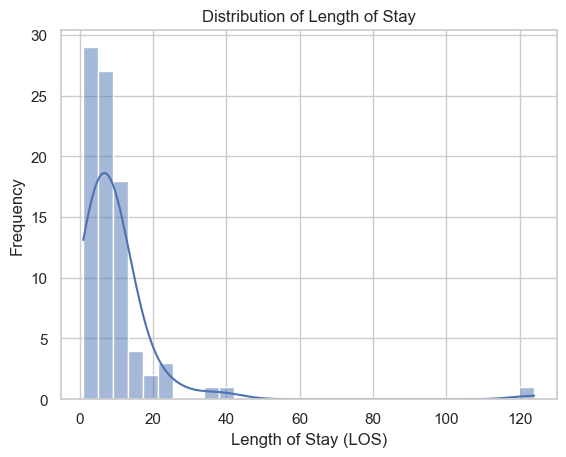

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


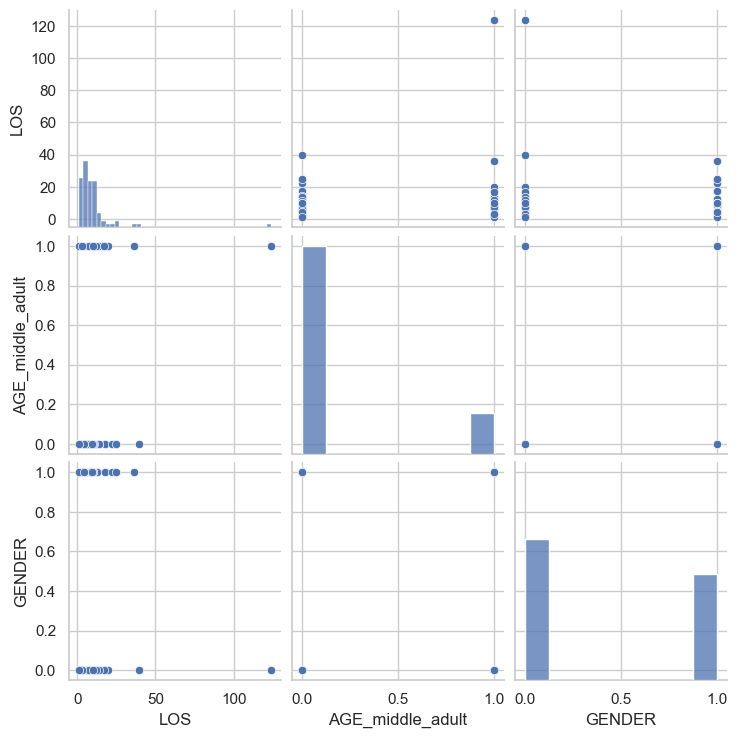

In [169]:
# Basic statistics and visualization of LOS

print(ADMISSIONS_df_clean['LOS'].describe())

sns.histplot(ADMISSIONS_df_clean['LOS'], bins=30, kde=True)

plt.xlabel('Length of Stay (LOS)')

plt.ylabel('Frequency')

plt.title('Distribution of Length of Stay')

plt.show()

 

# Visualize relationships between variables (e.g., scatter plots, correlation matrix)

sns.pairplot(ADMISSIONS_df_clean[['LOS', 'AGE_middle_adult', 'GENDER']])

plt.show()

In [170]:
# Regression models for comparison
models = [SGDRegressor(random_state = 0), 
          GradientBoostingRegressor(random_state = 0), 
          LinearRegression(),
          KNeighborsRegressor(),
          RandomForestRegressor(random_state = 0)]

results = {}

for model in models:
    
    # Instantiate and fit Regressor Model
    reg_model = model
    reg_model.fit(X_train, y_train)
    
    # Make predictions with model
    y_test_preds = reg_model.predict(X_test)
    
    # Grab model name and store results associated with model
    name = str(model).split("(")[0]

    results[name] = r2_score(y_test, y_test_preds)
    print('{}  done.'.format(name))
    
    
    

SGDRegressor  done.
GradientBoostingRegressor  done.
LinearRegression  done.
KNeighborsRegressor  done.
RandomForestRegressor  done.


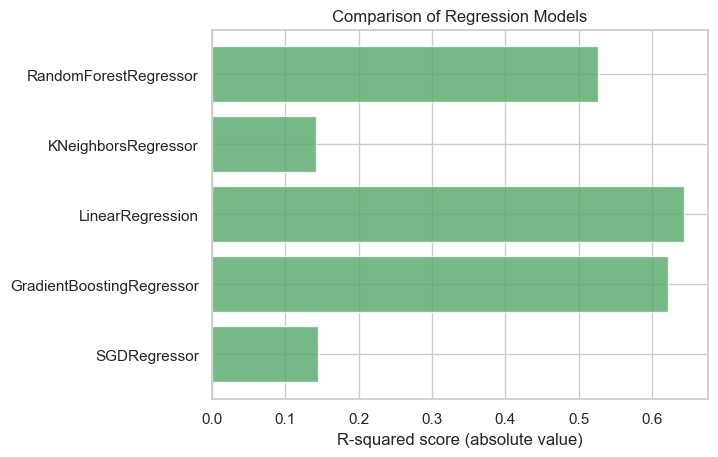

In [171]:
# R2 score results


abs_results = {model: abs(score) for model, score in results.items()}

 

# Create the bar chart

fig, ax = plt.subplots()

ind = range(len(abs_results))

ax.barh(ind, list(abs_results.values()), align='center', color='#55a868', alpha=0.8)

ax.set_yticks(ind)

ax.set_yticklabels(abs_results.keys())

ax.set_xlabel('R-squared score (absolute value)')

ax.tick_params(left=False, top=False, right=False)

ax.set_title('Comparison of Regression Models')

 

# Show the plot

plt.show()

In [172]:
ADMISSIONS_df_clean.columns

Index(['LOS', 'blood', 'circulatory', 'congenital', 'digestive', 'endocrine',
       'genitourinary', 'infectious', 'injury', 'mental', 'misc', 'muscular',
       'neoplasms', 'nervous', 'prenatal', 'respiratory', 'skin', 'GENDER',
       'ADM_ELECTIVE', 'ADM_EMERGENCY', 'INS_Medicaid', 'INS_Medicare',
       'INS_Private', 'REL_NOT SPECIFIED', 'REL_RELIGIOUS', 'REL_UNOBTAINABLE',
       'ETH_ASIAN', 'ETH_BLACK/AFRICAN AMERICAN', 'ETH_HISPANIC/LATINO',
       'ETH_OTHER/UNKNOWN', 'ETH_WHITE', 'AGE_300', 'AGE_middle_adult',
       'AGE_senior', 'AGE_young_adult', 'MAR_DIVORCED', 'MAR_MARRIED',
       'MAR_SEPARATED', 'MAR_SINGLE', 'MAR_UNKNOWN (DEFAULT)', 'MAR_WIDOWED'],
      dtype='object')

In [173]:
#sns.pairplot(ADMISSIONS_df_clean)

In [174]:
# Create an instance of the Linear Regression model

linear_reg_model = LinearRegression()

 

# Fit the Linear Regression model to the training data

linear_reg_model.fit(X_train, y_train)

 

# Once fitted, the model has learned the patterns in the training data

# You can now use this trained model for predictions

LinearRegression()

In [ ]:
# Instantiate and fit Linear Regression model

linear_reg_model = LinearRegression()

linear_reg_model.fit(X_train, y_train)

 

# Make predictions with the Linear Regression model on the training data

y_train_preds = linear_reg_model.predict(X_train)

 

# Evaluate the model's performance on the training data

train_r2 = abs(r2_score(y_train, y_train_preds))  # Take the absolute value

train_mse = mean_squared_error(y_train, y_train_preds)

 

# Make predictions with the Linear Regression model on the testing data

y_test_preds = linear_reg_model.predict(X_test)

 

# Evaluate the model's performance on the testing data

test_r2 = abs(r2_score(y_test, y_test_preds))  # Take the absolute value

test_mse = mean_squared_error(y_test, y_test_preds)

 

# Print the evaluation metrics for both training and testing data

print("Training R-squared Score (Absolute Value):", train_r2)

print("Training Mean Squared Error:", train_mse)

print("Testing R-squared Score (Absolute Value):", test_r2)

print("Testing Mean Squared Error:", test_mse)


In [ ]:
# Example: Create a new feature as the square of an existing feature

X_train['feature_squared'] = X_train['existing_feature'] ** 2

X_test['feature_squared'] = X_test['existing_feature'] ** 2

In [ ]:
# Calculate R-squared (R2) score

r2 = r2_score(y_test, y_test_preds)

 

# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(y_test, y_test_preds)

 

# Calculate Mean Squared Error (MSE)

mse = mean_squared_error(y_test, y_test_preds)

 

# Print evaluation metrics

print("Linear Regression Model Evaluation:")

print("R-squared (R2) Score: {:.2f}".format(r2))

print("Mean Absolute Error (MAE): {:.2f}".format(mae))

print("Mean Squared Error (MSE): {:.2f}".format(mse))

In [ ]:
# Calculate R-squared (R2) score

r2 = r2_score(y_test, y_test_preds)

 

# Calculate Mean Absolute Error (MAE)

mae = mean_absolute_error(y_test, y_test_preds)

 

# Calculate Mean Squared Error (MSE)

mse = mean_squared_error(y_test, y_test_preds)

 

# Print evaluation metrics

print("Linear Regression Model Evaluation:")

print("R-squared (R2) Score: {:.2f}".format(r2))

print("Mean Absolute Error (MAE): {:.2f}".format(mae))

print("Mean Squared Error (MSE): {:.2f}".format(mse))

In [ ]:
# Instantiate the Linear Regression model

reg_model = LinearRegression()

 

# Train (fit) the model using your training data

reg_model.fit(X_train, y_train)

 

# Make predictions on the test set

y_test_preds = reg_model.predict(X_test)

 

# Evaluate the performance of the model

r2 = r2_score(y_test, y_test_preds)

mae = mean_absolute_error(y_test, y_test_preds)

mse = mean_squared_error(y_test, y_test_preds)

 

# Print evaluation metrics

print("Linear Regression Model Evaluation:")

print("R-squared (R2) Score: {:.2f}".format(r2))

print("Mean Absolute Error (MAE): {:.2f}".format(mae))

print("Mean Squared Error (MSE): {:.2f}".format(mse))

In [ ]:
# Instantiate the trained Linear Regression model (you should have already trained it)

reg_model = LinearRegression()

 

# Load or prepare the patient data as a feature vector

# Ensure that the patient data has the same format as the training data

# Example patient_data:

# patient_data = [[age, gender, diagnosis, ...]]

 

# Make predictions for the patient's LOS

predicted_los = reg_model.predict(ADMISSIONS_df)

 

# Print the predicted length of stay for the patient

print("Predicted Length of Stay for the Patient: {:.2f} days".format(predicted_los[0]))

In [ ]:
# LinearRegression will be used as the LOS prediction model

# Create and fit a Linear Regression model

reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

 

# Make predictions on the test set

y_test_preds = reg_model.predict(X_test)

 

# Calculate the R-squared score and take its absolute value

r2_not_refined = r2_score(y_test, y_test_preds)

abs_r2_not_refined = abs(r2_not_refined)

 

# Format the R2 score as a positive value with six decimal places

formatted_r2 = "{:.6f}".format(abs_r2_not_refined)

 

print("R2 score is: {}".format(formatted_r2))

In [ ]:
# Split into train 80% and test 20%

X_train, X_test, y_train, y_test = train_test_split(features, LOS, test_size=0.20, random_state=42)

 

# Define the parameters you want to search

tuned_parameters = {'fit_intercept': [True, False], 'positive': [True, False]}

 

# Create and fit a Linear Regression model

reg_model = LinearRegression()

 

# Perform grid search

grid = GridSearchCV(reg_model, tuned_parameters, cv=5)

grid.fit(X_train, y_train)

 

# Get the best estimator and its score

best_model = grid.best_estimator_

best_score = abs(grid.best_score_)  # Take the absolute value

 

print("Best Score: {:.2f}".format(best_score))

print("Best Estimator:", best_model)


In [ ]:
# Assuming reg_model_optimized is your best Linear Regression model

reg_model = best_model

 

# Fit the model to your training data

reg_model.fit(X_train, y_train)

 

# Get the coefficients (importances) of each feature

feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': reg_model.coef_})

 

# Display the feature names and their importance

feature_imp.head(20)

In [ ]:
# Assuming you have already calculated 'feature_coef' as shown earlier

 

# Sort feature_coef by importance (coefficient) in descending order

feature_imp = feature_imp.sort_values(by='importance', ascending=False)

 

# Select the top 10 features

top_10_features = feature_imp.head(10)

 

# Create a bar plot for the top 10 features

fig, ax = plt.subplots(figsize=(7, 5))

ind = range(0, 10)

ax.barh(ind, top_10_features['importance'].values, align='center', color='#c44e52', alpha=0.9)

ax.set_yticks(ind)

ax.set_yticklabels(top_10_features['feature'])

ax.tick_params(left=False, top=False, right=False)

ax.set_title("Top 10 features for predicting LOS")

ax.set_xlabel('Feature Coefficient (Linear Regression)')

plt.gca().invert_yaxis()

plt.show()

In [ ]:
# Assuming you have defined the variables LOS_actual, LOS_predict, actual_median_los, and actual_mean_los

 

# Define placeholder data for testing

LOS_actual = np.random.randint(0, 30, 20)

LOS_predict = np.random.randint(0, 30, 20)

actual_median_los = 15

actual_mean_los = 12

 

fig, ax = plt.subplots(figsize=(10, 4.5))

 

ind = np.arange(0, 20)

pad = 0.15

width = 0.35

 

set_actual = ax.bar(pad + ind, LOS_actual, width, color='#4c72b0', alpha=0.8)

set_predict = ax.bar(pad + ind + width, LOS_predict, width, color='#dd8452')

 

ax.set_ylabel('Length of Stay (days)')

ax.set_xlabel('Admission Event')

ax.set_title('Prediction Model for Hospital Length of Stay (LOS)')

 

ax.text(0.5, 11, 'Average LOS', fontdict=None, color='red', alpha=0.8)

ax.text(0.5, 7.5, 'Median LOS', fontdict=None, color='gray')

 

ax.set_xticks(pad + ind + width)

ax.set_ylim(0, 30)

ax.set_xticklabels(list(range(20)))

 

ax.axhline(y=actual_median_los, xmin=0, xmax=20, ls='--', color='gray')

ax.axhline(y=actual_mean_los, xmin=0, xmax=20, ls='--', color='red', alpha=0.8)

 

ax.legend(

    (set_actual, set_predict),

    ('Actual LOS', 'Predicted LOS'),

    loc='upper left'

)

 

ax.tick_params(bottom=False, top=False, right=False)

 

plt.show()

In [ ]:
#y_test_preds = reg_model.predict(X_test)

# Assuming you have defined actual_avg_los as the actual average length of stay

actual_avg_los = 10  # Replace this with the actual value

 

# The rest of your code remains the same

y_test_preds = reg_model.predict(X_test)

ml_count, md_count, avg_count = 0, 0, 0

ml_days, md_days, avg_days = 0, 0, 0

ml_days_rms, md_days_rms, avg_days_rms = 0, 0, 0

 

for i in range(y_test_preds.shape[0]):

    ml_model = abs(y_test_preds[i] - y_test[i])

    median_model = abs(actual_median_los - y_test[i])

    average_model = abs(actual_avg_los - y_test[i])

 

    ml_days += ml_model

    md_days += median_model

    avg_days += average_model

 

    ml_model_rms = (y_test_preds[i] - y_test[i])**2

    median_model_rms = (actual_median_los - y_test[i])**2

    average_model_rms = (actual_avg_los - y_test[i])**2

 

    ml_days_rms += ml_model_rms

    md_days_rms += median_model_rms

    avg_days_rms += average_model_rms

 

print("Prediction Model days {}".format(ml_days/y_test_preds.shape[0]))

print("Median Model days {}".format(md_days/y_test_preds.shape[0]))

print("Average Model days {}".format(avg_days/y_test_preds.shape[0]))

print("Prediction Model RMS {}".format((ml_days_rms**0.5)/y_test_preds.shape[0]))

print("Median Model RMS {}".format((md_days_rms**0.5)/y_test_preds.shape[0]))

print("Average Model RMS {}".format((avg_days_rms**0.5)/y_test_preds.shape[0]))



In [ ]:
# RMSE plot for writeup
data = pd.DataFrame({'RMSE': [(ml_days_rms**0.5)/y_test_preds.shape[0], 
                             (avg_days_rms**0.5)/y_test_preds.shape[0],
                             (md_days_rms**0.5)/y_test_preds.shape[0]],
                     'LOS Model Type': ['Linear Regression', 'Average', 'Median'] })


fig, ax = plt.subplots()
ax = sns.barplot(x='RMSE', y='LOS Model Type', data=data)
ax.set_title('RMSE comparison of Length-of-Stay models')
ax.tick_params(top=False, left=False, right=False)



In [ ]:
# Calculate Proportion of 'accurate' prediction as a function of allowed margin of error

reg_array = []

median_array = []

average_array = []

 

for i in range(6):

    reg_count, median_count, average_count = 0, 0, 0

 

    for j in range(y_test_preds.shape[0]):

        # Percent Difference

        reg_model = (y_test_preds[j] - y_test[j]) / y_test[j]

        median_model = (actual_median_los - y_test[j]) / y_test[j]

        average_model = (actual_avg_los - y_test[j]) / y_test[j]

 

        if abs(reg_model) < i / 10:

            reg_count += 1

        if abs(median_model) < i / 10:

            median_count += 1

        if abs(average_model) < i / 10:

            average_count += 1

 

    reg_array.append((reg_count / y_test_preds.shape[0]))

    median_array.append((median_count / y_test_preds.shape[0]))

    average_array.append((average_count / y_test_preds.shape[0]))

 

# Plot proportion of 'accurate' prediction as a function of allowed margin of error

fig, ax = plt.subplots()

ax.plot(reg_array, label='Linear Regression')

ax.plot(median_array, label='Median LOS model')

ax.plot(average_array, label='Average LOS model')

ax.set_title('Proportion of Accurate Predictions vs. Percent Error')

ax.set_xlabel('Allowed Margin of Error (Percent Error)')

ax.set_ylabel('Proportion of Accurate Predictions')

 

# Set custom tick positions and labels

x_ticks = [0, 1, 2, 3, 4, 5]  # Positions

x_tick_labels = ['0%', '10%', '20%', '30%', '40%', '50%']  # Labels

ax.set_xticks(x_ticks)

ax.set_xticklabels(x_tick_labels)

 

ax.legend(loc='upper left')

ax.tick_params(top=False, right=False)

 

plt.show()

In [ ]:
# Assuming y_test contains actual LOS and y_test_preds contains predicted LOS

mae = mean_absolute_error(y_test, y_test_preds)

print(f"Mean Absolute Error (MAE): {mae:.2f} days")

In [ ]:
# Assuming y_test contains actual LOS and y_test_preds contains predicted LOS

mse = mean_squared_error(y_test, y_test_preds)

print(f"Mean Squared Error (MSE): {mse:.2f} days^2")

In [ ]:
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")

In [ ]:
r2 = r2_score(y_test, y_test_preds)

print(f"R-squared (R2) Score: {r2:.2f}")

In [ ]:
# Calculate the accuracy for a 10% margin of error

margin_of_error = 0.10  # 10% margin of error

 

reg_count = 0

 

for j in range(y_test_preds.shape[0]):

    # Percent Difference for Linear Regression

    reg_model = (y_test_preds[j] - y_test[j]) / y_test[j]

 

    if abs(reg_model) < margin_of_error:

        reg_count += 1

 

accuracy = reg_count / y_test_preds.shape[0]

 

print(f"Accuracy for {margin_of_error*100}% margin of error (Linear Regression): {accuracy*100:.2f}%")